<a href="https://colab.research.google.com/github/DrUkachi/online_retail_project/blob/main/online_retail_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis

This section of the project will be focused on analysing the properties of this time series.

It will focus on investigating the error, trend and seasonality (ETS) of the data.

In addition, several observations using both visualisation and statistical methods will be carried on to investigate the stationarity of the time-series.

Doing this will not only inform the configuration or parameters that will be chosen when performing the Time Series modelling, but will also provide an understanding on which models would work best.



In [2]:
# Importing the necessary libraries

import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

In [3]:
CLEANED_DATASET_PATH = "/content/drive/MyDrive/Colab_Notebooks/online_retail/further_cleaned_retail_data.csv"
cleaned_data = pd.read_csv(CLEANED_DATASET_PATH)
cleaned_data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
FOLDER_PATH = "/content/drive/MyDrive/Colab_Notebooks/online_retail/"

## Time Series Decomposition

The goal of this project is to develop models that can predict the weekly aggregated forecast sales for the next four weeks. The online retail sales data will first be aggregated by using Quantity. 

In [6]:
# Generate the aggregated weekly sales
dated_retail_data = cleaned_data.copy()
dated_retail_data["Date"] = pd.to_datetime(cleaned_data["InvoiceDate"]) - pd.to_timedelta(7, unit="d")
dated_retail_data.index = dated_retail_data["Date"]
# resampling to get the weekly sales and returns
weekly_sale = dated_retail_data[dated_retail_data['Quantity']>0].Quantity.resample('W').sum()
weekly_retail = dated_retail_data[dated_retail_data['Quantity']<0].Quantity.resample('W').sum().abs()

## Task 1: Performing Automatic time series decomposition.

This section of the experiment the Level, Trend, Seasonality and Noise is investigated using Python's Statmodels Seasonal Compose module. The resulting plot shows a visualisation of the 

*   Level
*   Trend
*   Seasonality and 
*   Noise

<Figure size 4000x1600 with 0 Axes>

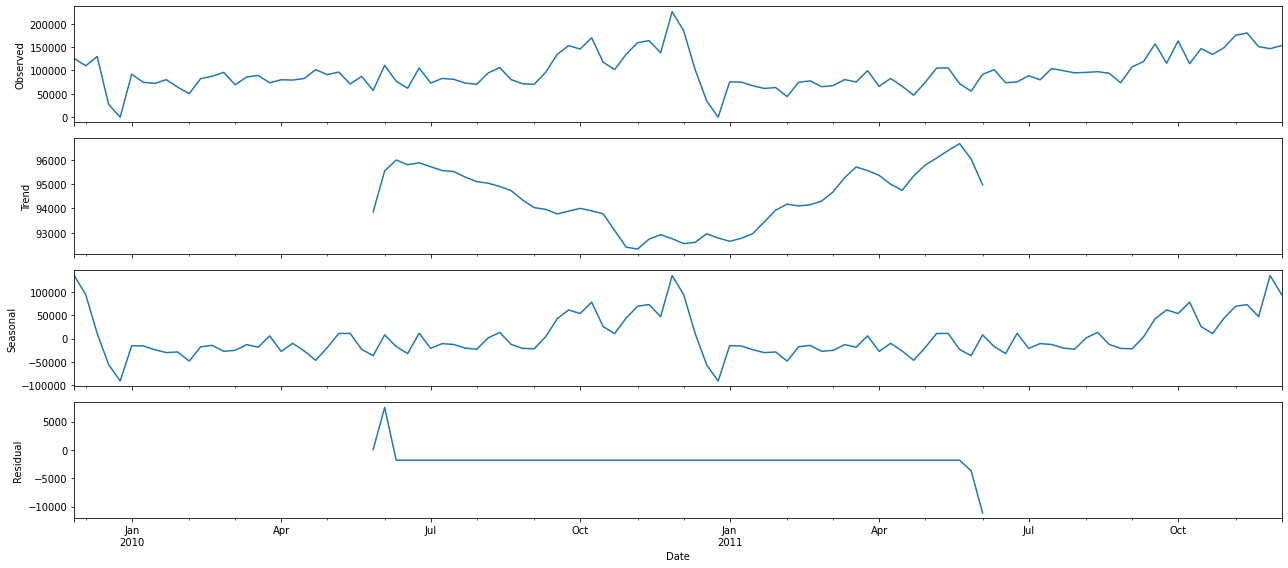

In [10]:
rcParams['figure.figsize'] = 18,8
plt.figure(num=None, figsize=(50, 20), dpi=80,
           facecolor='w', edgecolor='k')
series = weekly_sale
result = seasonal_decompose(series, model='additive')
result.plot();

## Interpretation of obtained Decomposition Plots
1. The individual componets are additive.

2. The `observed` plot shows the actual time-series plot.

3. The `Trend` plot shows the trend component. This trend shows an increasing pattern around the month of May 2010, and then a gradual decrease from July 2010 to Nov 2010, then a gradual increase from December 2010 to May/June 2011.

4. The `Seasonal` plot shows a short term repeating cycle in the series. From the plot the seasonality is not some what obvious. This implies that its seasonal nature might not have a significant impact to the pattern of the time series.

5. The `Residual` plot shows the `error` term. A high portion of the residual term is close to 0. This suggests a good fit for the additive model. However, it shows a spike in June 2010, and then a downward spike in June 2011. This also points out important parts of the `Trend` plot.


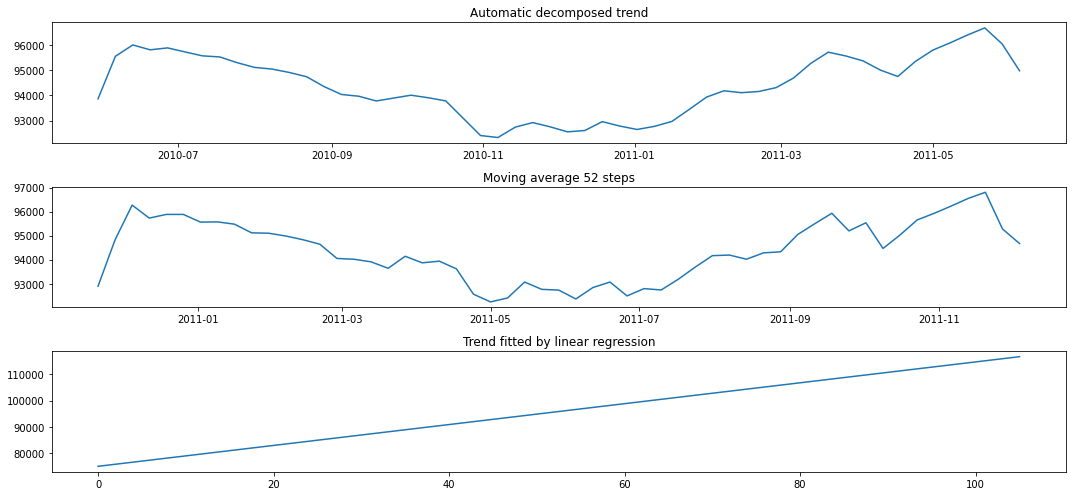

In [ ]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = weekly_sale.rolling(52).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 52 steps")


X = [i for i in range(0, len(weekly_sale))]
X = np.reshape(X, (len(X), 1))
y = weekly_sale.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

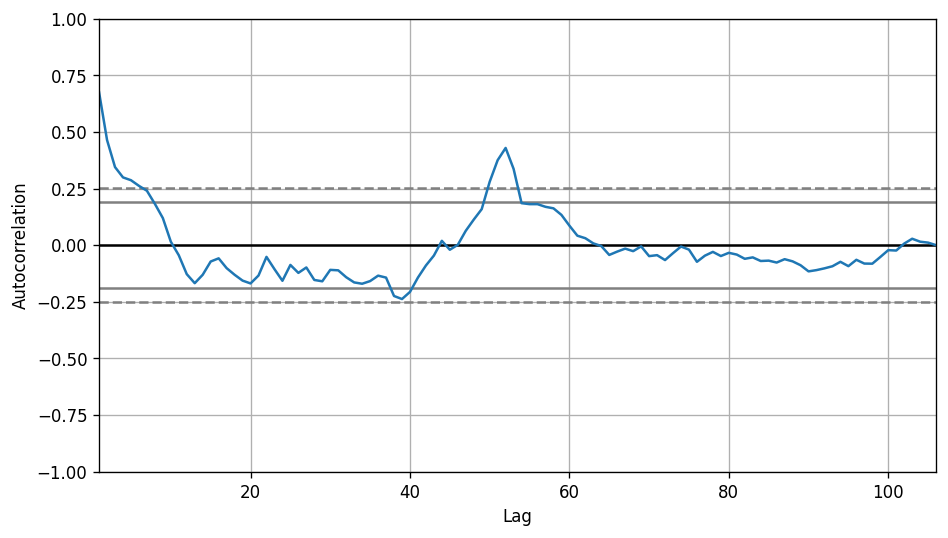

In [ ]:
# Draw Plot
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(series.tolist())

## Checking for noise in the data


Text(0.5, 1.0, 'Mean over time')

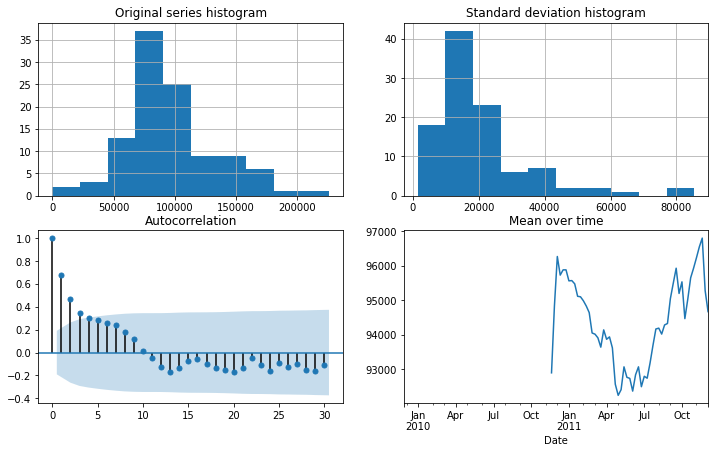

In [11]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

series.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = series.rolling(4).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = series.rolling(52).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


The above plot shows that little or no noise appears in the time-series. This is evident because:
1. The time series follows a Gaussian Distribution.
2. The mean and standard deviation are within a small range/or almost constant over time.

## Test for Stationarity

Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. 

We will need to test and check for the stationarity of the weekly aggregated sales. This will inform whether there will be a need for any transformations.

To carry out these tests, several plots will be used:
1. **ACF Plot**: The autocorrelation function (ACF) shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.

2. **PACF Plot**: The partial autocorrelation function (PACF) looks at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

3. Obtaining the mean and standard deviation at different parts of the time-series.

4. Carrying out the Augumented Dickey-Fuller (ADF) test

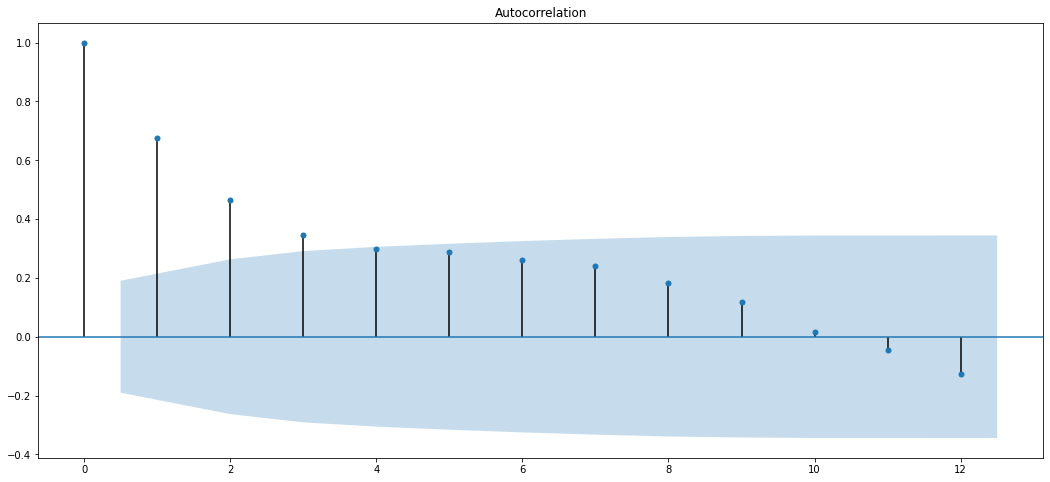

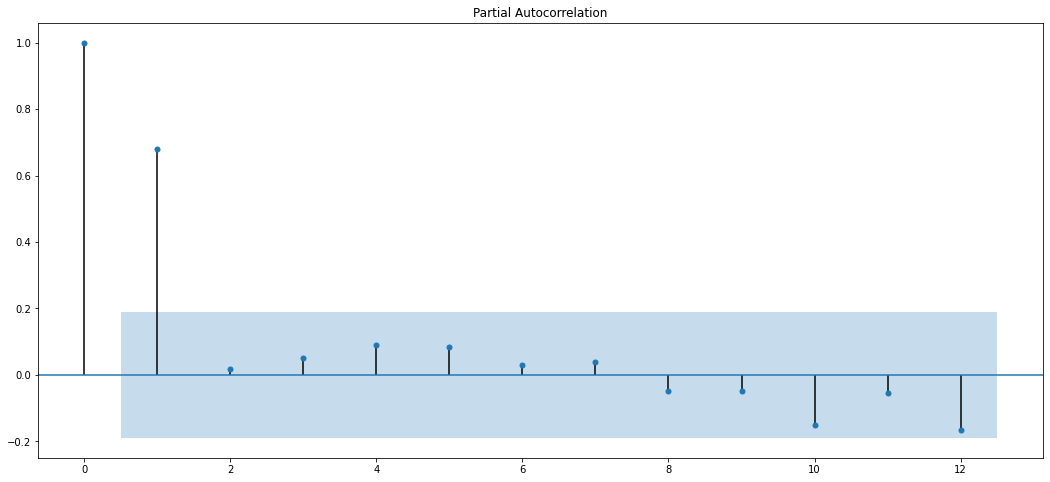

In [13]:
# Making the ACF and PACF plots
plot_acf(series, lags=12)
plot_pacf(series, lags=12)
plt.show()

In [ ]:
# Obtaining the mean and standard deviation at different part of the time series
# can help show how stationary the data is.
split = round(len(series) / 2)
X1, X2 = series[0:split], series[split:]
mean_1, mean_2 = X1.mean(), X2.mean()
var_1, var_2 = X1.var(), X2.var()
print('mean_1=%f, mean_2=%f' % (mean_1, mean_2))
print('var_1=%f, var_2=%f' % (var_1, var_2))

mean_1=95407.358491, mean_2=96374.283019
var_1=1398585412.657475, var_2=1512704899.745283


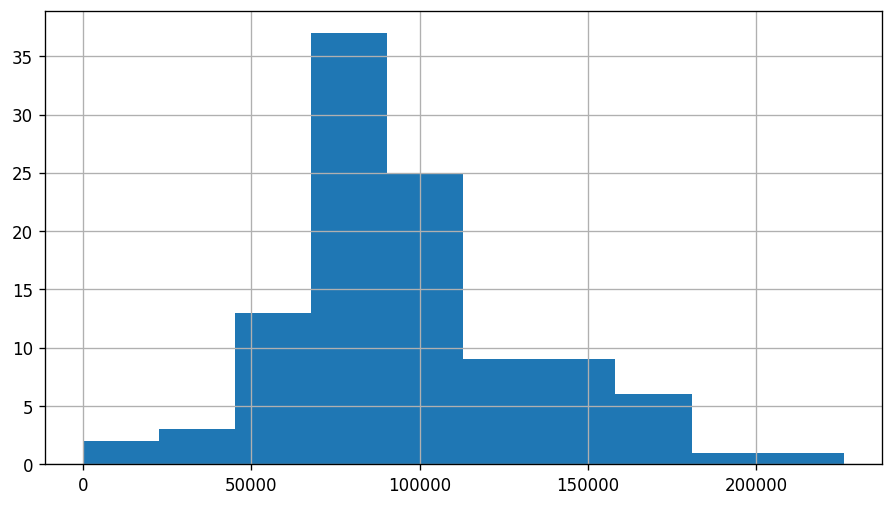

In [ ]:
series.hist()
plt.show()

## Augmented Dickey-Fuller test

Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

In [ ]:
# Carrying out the ADF test for stationarity
result = adfuller(series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.280327
p-value: 0.000480
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


## Putting all the test for stationarity together


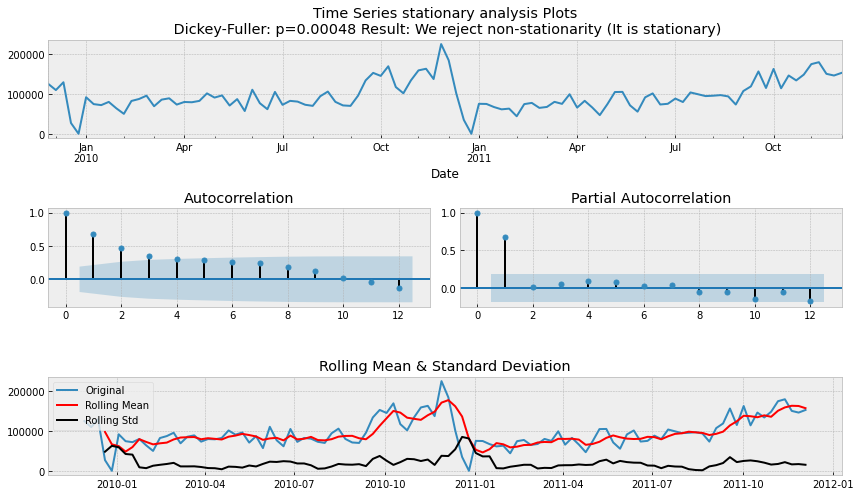

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject non-stationarity (It is stationary)" if p_value <= 0.05 else "We can not reject non-stationarity (It is non stationary)"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = series.rolling(window=4).mean()
        rolstd = series.rolling(window=4).std()

        # Plot rolling statistics:
        orig = plt.plot(series, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(series, lags=12)

In [ ]:
df_series.to_csv("/content/drive/MyDrive/Colab_Notebooks/online_retail/aggregated_weekly_sales_data.csv")

From the above tests, it can be seen that this data set is stationary. As it posses

1. Constant mean and standard deviation over time
2. From the ADF test, the p-value is below 0.05.

3. The ACF and PACF plots suggests that the AR(1) model would be most useful for the time-series.

This is becase we have one significant spike on the PACF plot with the lag of 12.
